In [1]:
# imports

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline  
%load_ext autoreload

### Calibration

In [3]:
import glob
from calibrator import Calibrator

calibration_images = []
for file in glob.glob("camera_cal/calibration*.jpg"):
    img = mpimg.imread(file)
    calibration_images.append(img)

calibrator = Calibrator(calibration_images,9,6)

test_images = []
for file in glob.glob("test_images/*.jpg"):
    img = mpimg.imread(file)
    test_images.append(img)

calibrated_images = []
for img in test_images:
    calibrated = calibrator.undistort(img)
    calibrated_images.append(calibrated)

print("calibrated test images")


calibrated test images


#### Calibration - visualisation

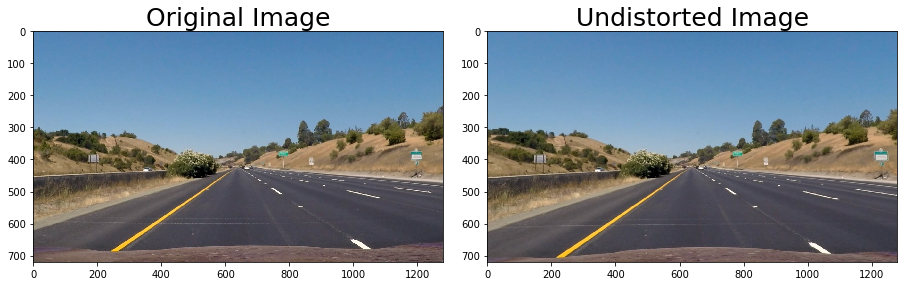

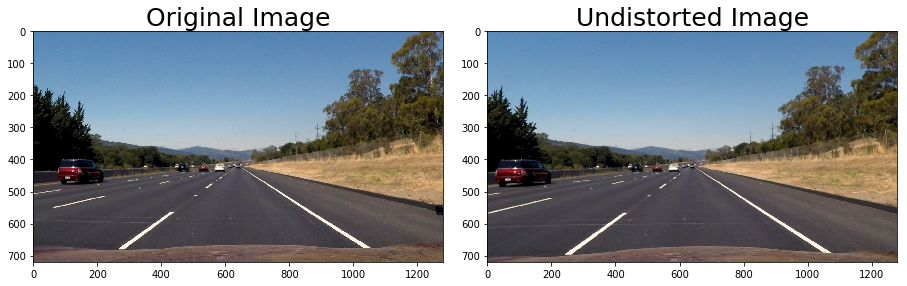

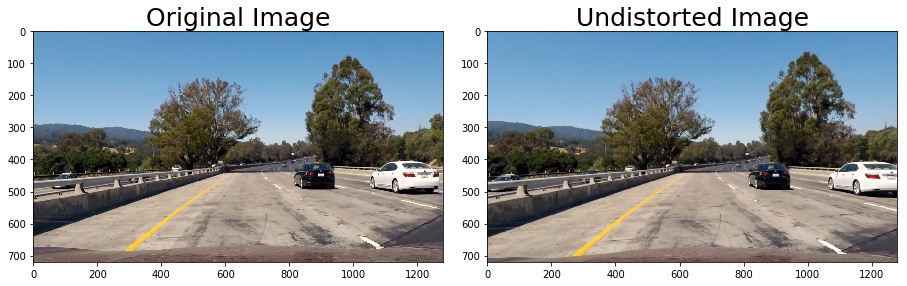

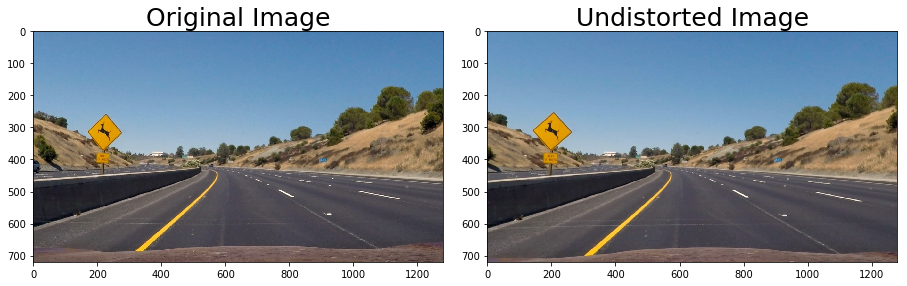

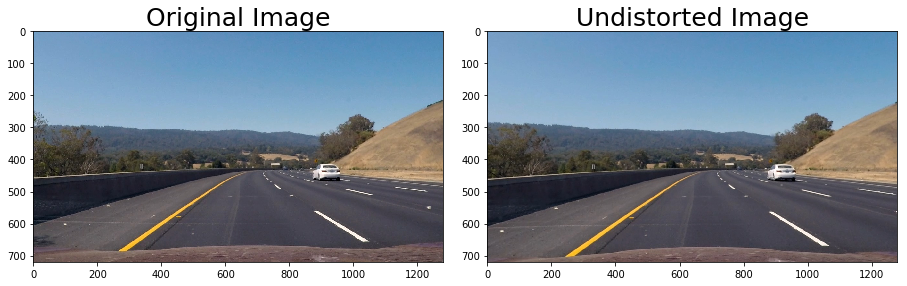

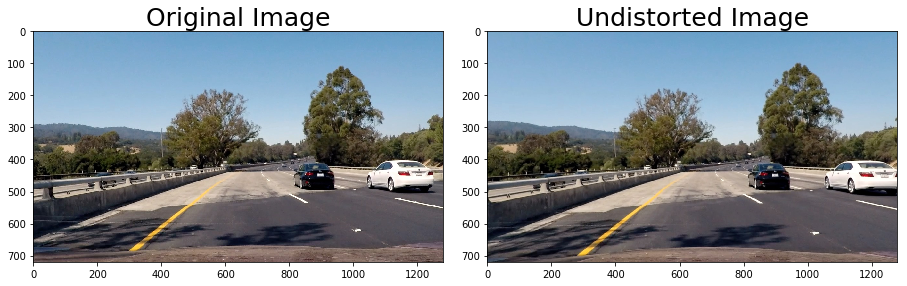

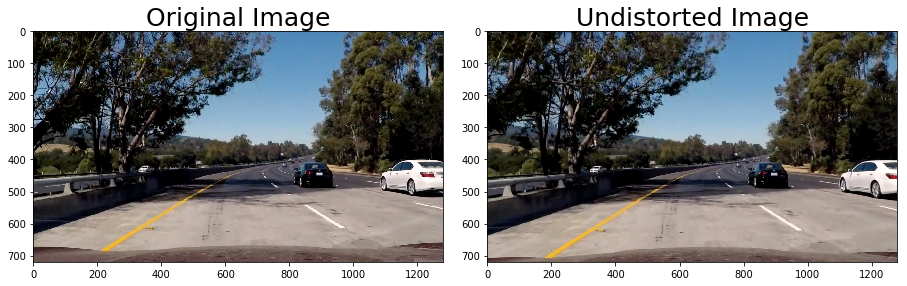

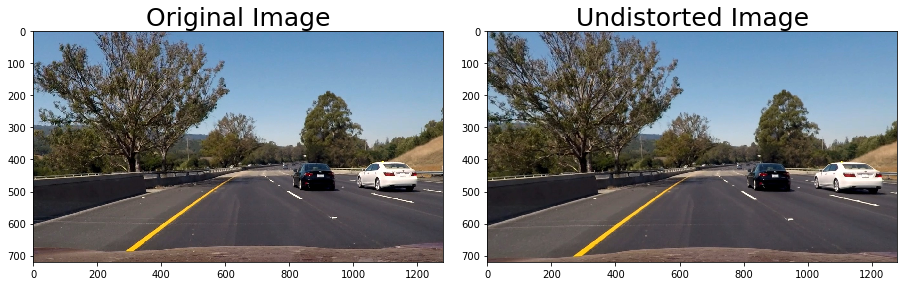

In [3]:
for i in range(len(calibrated_images)):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    f.tight_layout()
    ax1.imshow(test_images[i])
    ax1.set_title('Original Image', fontsize=25)
    ax2.imshow(calibrated_images[i])
    ax2.set_title('Undistorted Image', fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Transformation

In [11]:
from lane_warp import Transformer

transformer = Transformer()

transformed_images = []
for img in calibrated_images:
    transformed = transformer.transform(img)
    transformed_images.append(transformed)



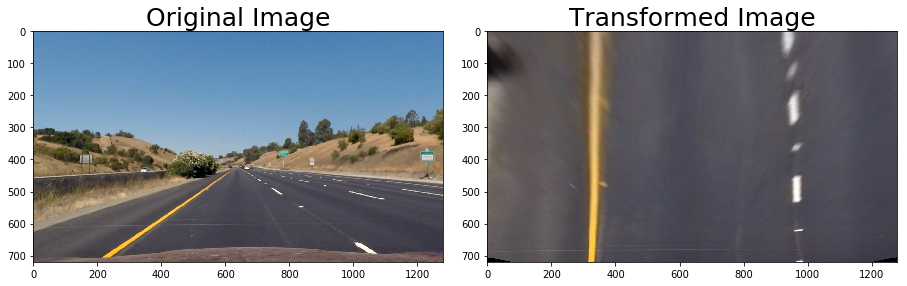

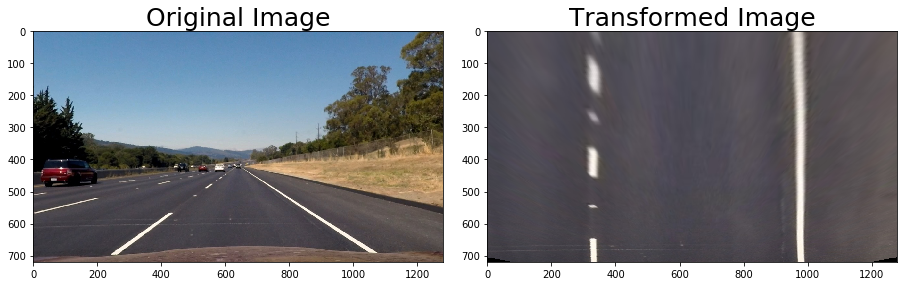

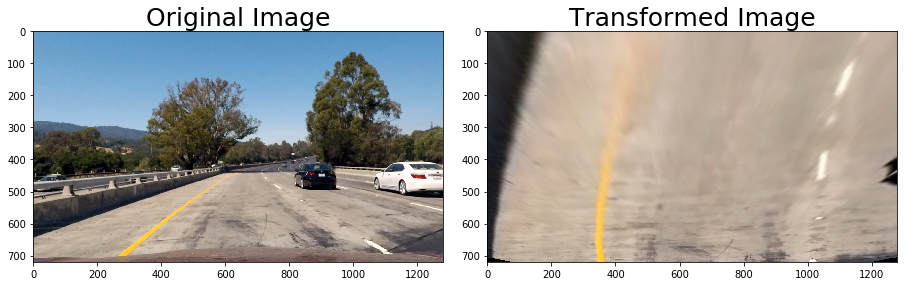

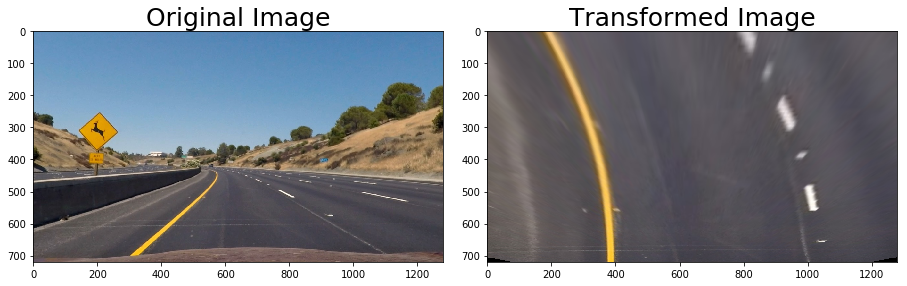

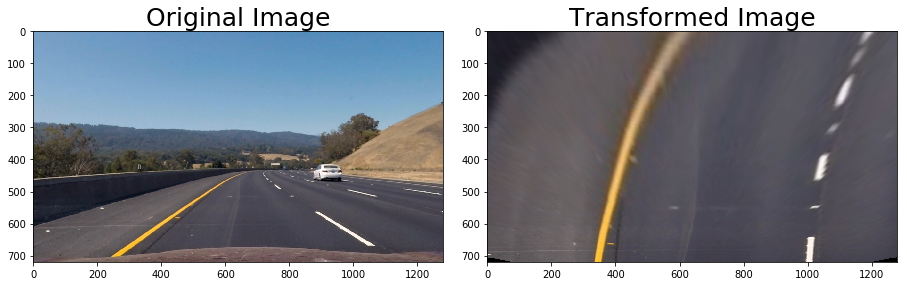

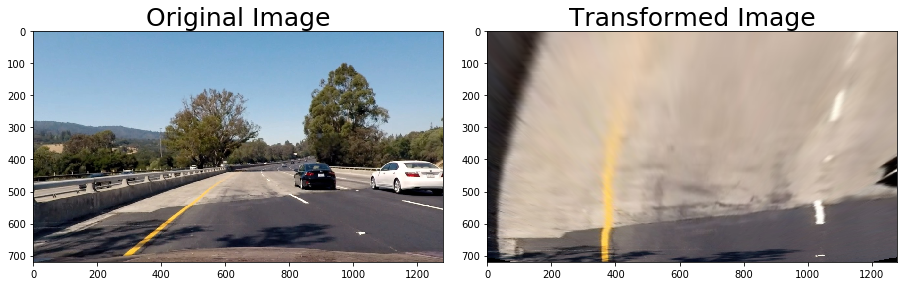

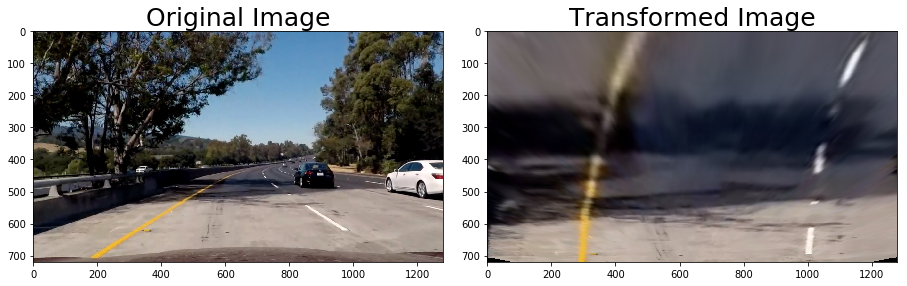

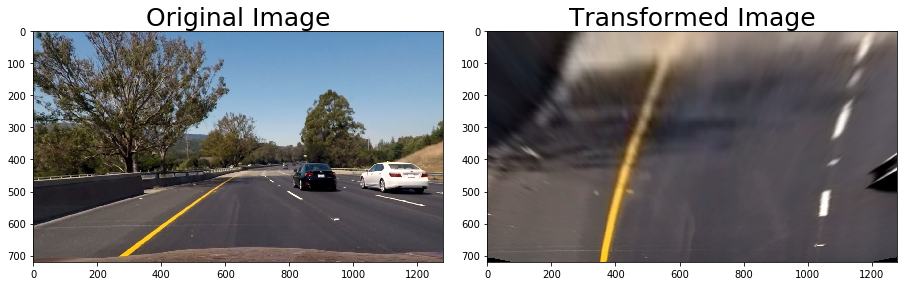

In [18]:
for i in range(len(calibrated_images)):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    f.tight_layout()
    ax1.imshow(calibrated_images[i])
    ax1.set_title('Original Image', fontsize=25)
    ax2.imshow(transformed_images[i])
    ax2.set_title('Transformed Image', fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


### Thresholding

In [17]:
import lane_finder

masked_images = []
for img in transformed_images:
    binary = lane_finder.lane_mask(img)
    masked_images.append(binary)


#### Thresholding - visualisation

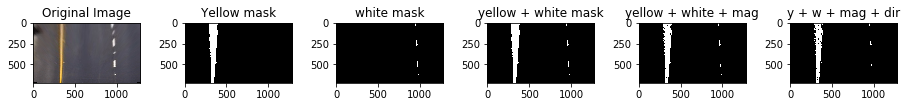

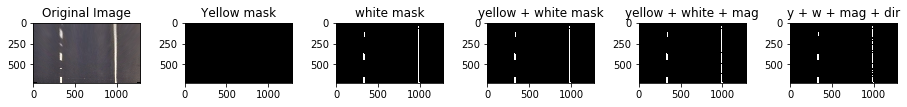

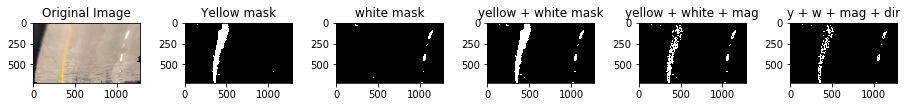

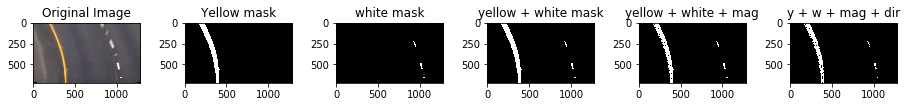

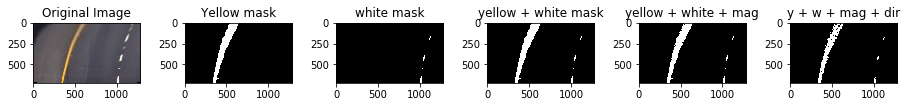

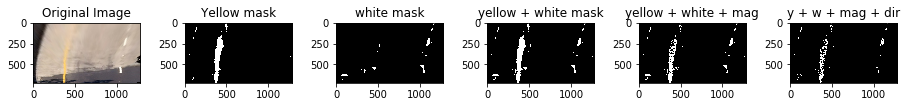

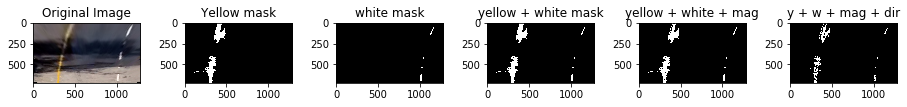

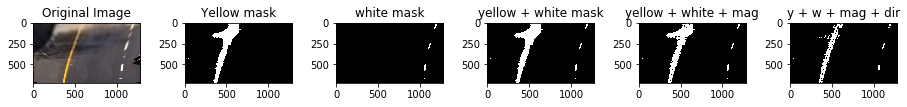

In [20]:
for i in range(len(calibrated_images)):
    
    img = transformed_images[i]
    
    mag = lane_finder.mag_threshold(img, sobel_kernel=3, mag_thresh=(1, 255))
    yellow = lane_finder.yellow_filter(img)
    dir_t = lane_finder.dir_threshold(img, sobel_kernel=15, thresh=(-0.8,0.8)) 
    white = lane_finder.white_filter(img)
    
    yellow_and_white = np.zeros_like(mag)
    yellow_and_white[(yellow > 0) | (white > 0)] = 1
    
    yellow_and_white_mag = np.zeros_like(mag)
    yellow_and_white_mag[(yellow_and_white > 0) & mag > 0] = 1
    
    binary = np.zeros_like(mag)
    binary[(dir_t > 0) & (yellow_and_white_mag > 0)] = 1

    f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(12, 5))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image')
    ax2.imshow(yellow, cmap = "gray")
    ax2.set_title('Yellow mask')
    ax3.imshow(white, cmap = "gray")
    ax3.set_title('white mask')
    ax4.imshow(yellow_and_white, cmap = "gray")
    ax4.set_title('yellow + white mask')
    ax5.imshow(yellow_and_white_mag, cmap = "gray")
    ax5.set_title('yellow + white + mag')
    ax6.imshow(masked_images[i], cmap = "gray")
    ax6.set_title('y + w + mag + dir')


    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


### Lane Finding

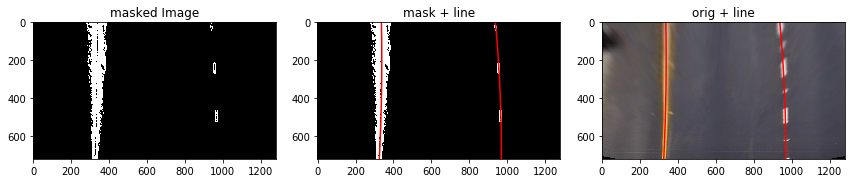

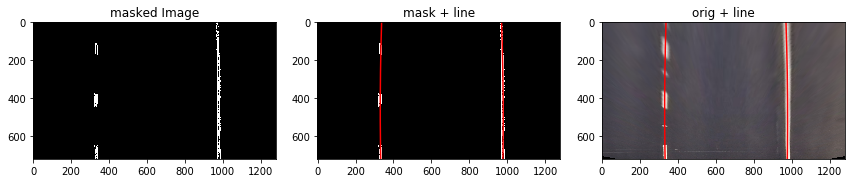

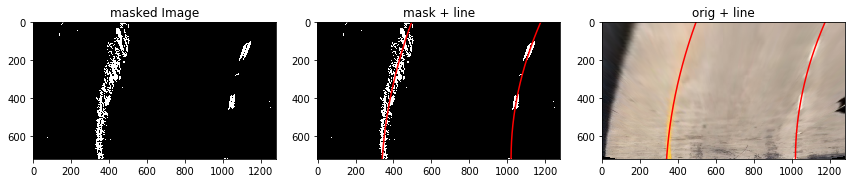

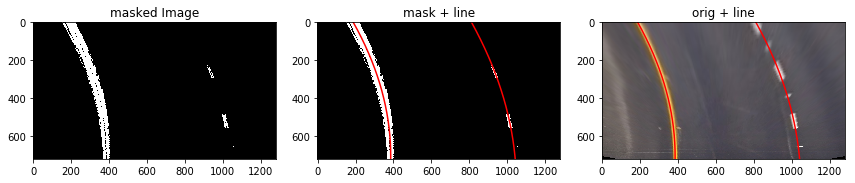

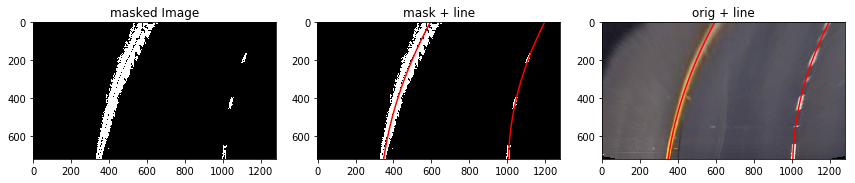

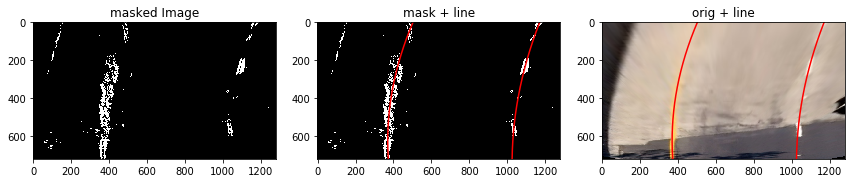

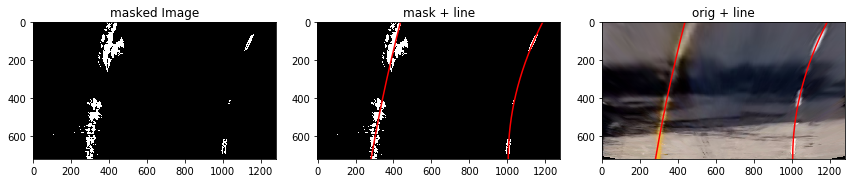

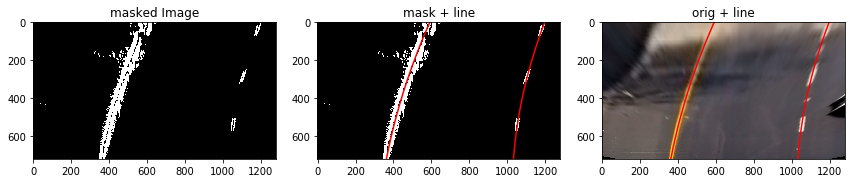

In [21]:
import lane_finder

for i in range(len(masked_images)):
    masked = masked_images[i]
    orig = transformed_images[i]
    left_fit, right_fit = lane_finder.line_equations(masked)

    ploty = np.linspace(0, masked.shape[0]-1, masked.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(masked).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
    f.tight_layout()
    ax1.imshow(masked, cmap = 'gray')
    ax1.set_title('masked Image')
    
    
    ax2.imshow(masked, cmap="gray")
    ax2.plot(left_fitx, ploty, color='red')
    ax2.plot(right_fitx, ploty, color='red')
    ax2.set_title('mask + line')

    ax3.imshow(orig)
    ax3.set_title('orig + line')
    ax3.plot(left_fitx, ploty, color='red')
    ax3.plot(right_fitx, ploty, color='red')





### Lane Curvature

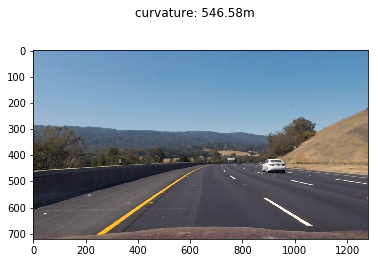

In [22]:
import lane_measurements

img = calibrated_images[4]
masked = masked_images[4]
left_fit, right_fit = lane_finder.line_equations(masked)
curvature_in_m = lane_measurements.curvature(left_fit,right_fit)
plt.suptitle('curvature: {0:.2f}m'.format(curvature_in_m))
plt.imshow(img)


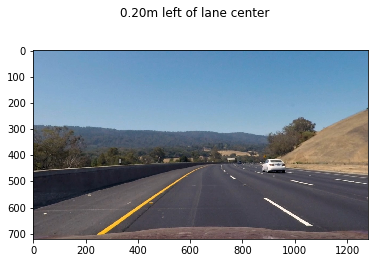

In [23]:
### Center offset finder

import lane_measurements

img = calibrated_images[4]
masked = masked_images[4]
left_fit, right_fit = lane_finder.line_equations(masked)
offset = lane_measurements.center_offset(left_fit,right_fit, masked.shape)
plt.suptitle('{0:.2f}m left of lane center'.format(offset))
plt.imshow(img)


### Lane overlay

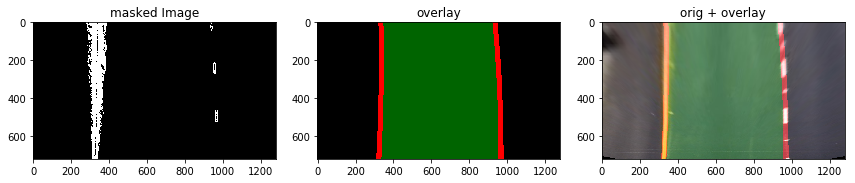

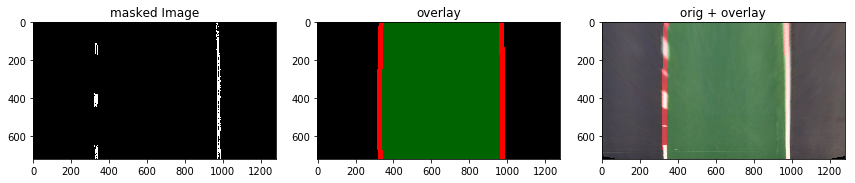

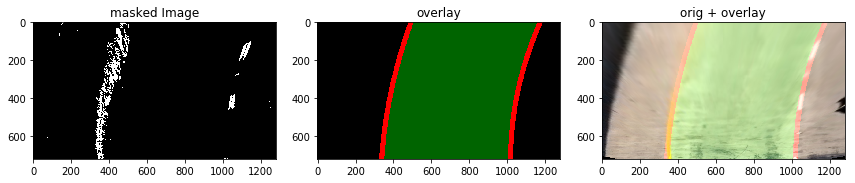

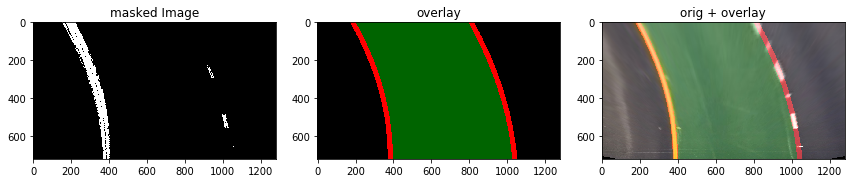

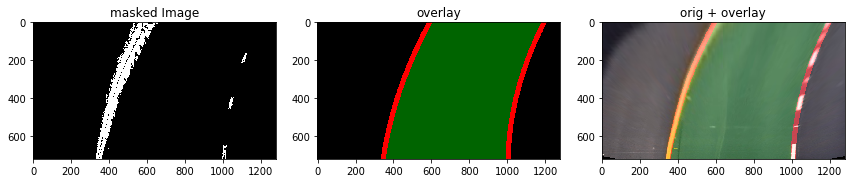

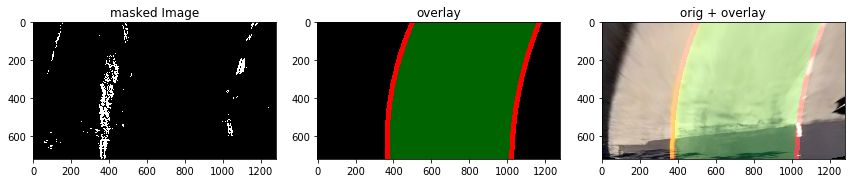

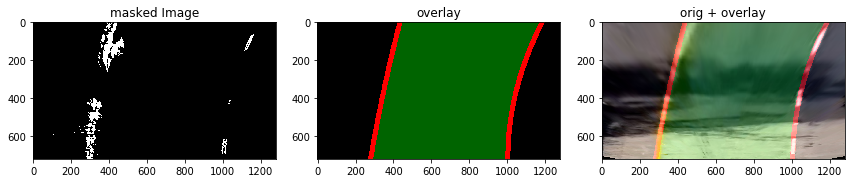

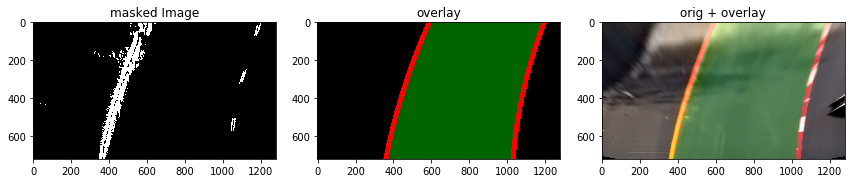

In [19]:
import overlay

for i in range(len(masked_images)):
    masked = masked_images[i]
    orig = transformed_images[i]
    left_fit, right_fit = lane_finder.line_equations(masked)
    frame_driving_info = overlay.lane_overlay(left_fit, right_fit,masked.shape)

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
    f.tight_layout()
    ax1.imshow(masked, cmap = 'gray')
    ax1.set_title('masked Image')
    
    ax2.imshow(frame_driving_info)
    ax2.set_title('overlay')
    
    both = cv2.addWeighted(orig, 1, frame_driving_info, 0.5, 0)

    ax3.imshow(both)
    ax3.set_title('orig + overlay')




        

### Inverse transformation

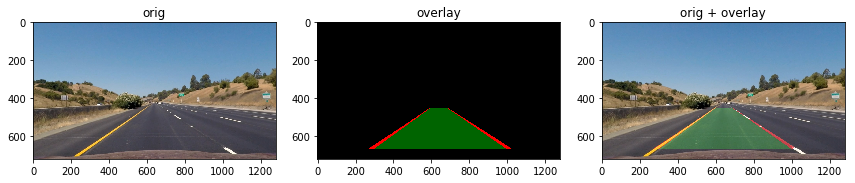

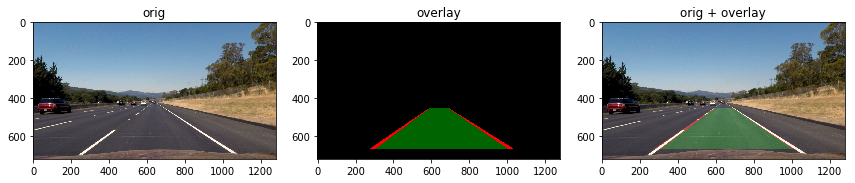

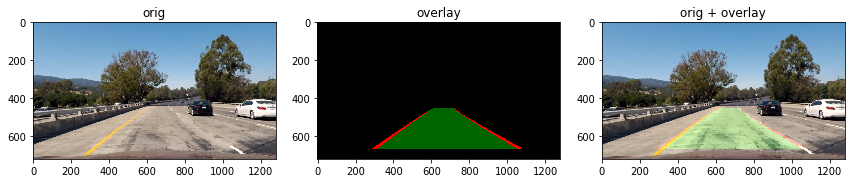

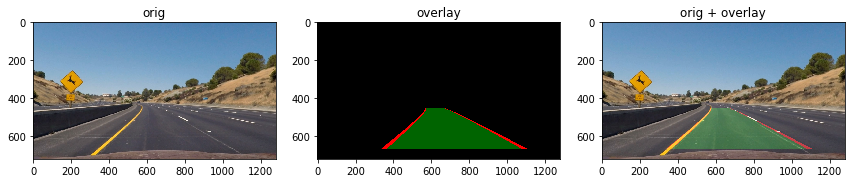

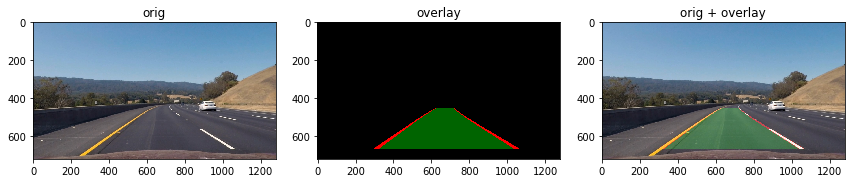

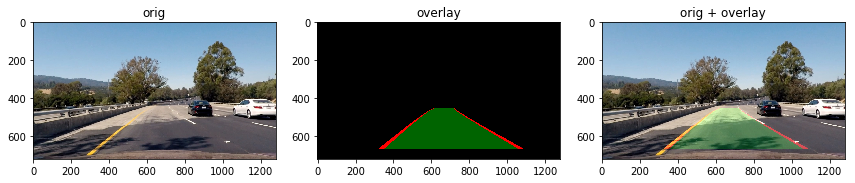

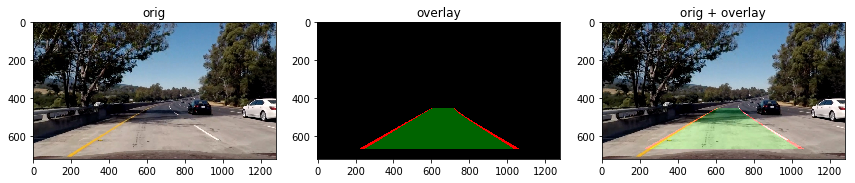

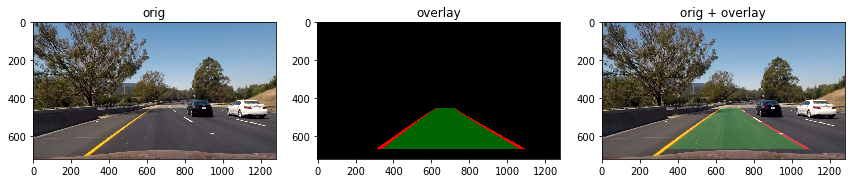

In [22]:
for i in range(len(masked_images)):
    masked = masked_images[i]
    orig = calibrated_images[i]
    left_fit, right_fit = lane_finder.line_equations(masked)
    frame_info = overlay.lane_overlay(left_fit, right_fit,masked.shape)
    frame_info = transformer.inverse_transform(frame_info)

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
    f.tight_layout()
    ax1.imshow(orig, cmap = 'gray')
    ax1.set_title('orig')
    
    ax2.imshow(frame_info)
    ax2.set_title('overlay')
    
    both = cv2.addWeighted(orig, 1, frame_info, 0.5, 0)

    ax3.imshow(both)
    ax3.set_title('orig + overlay')




### Image pipeline

In [25]:
def process_image(img):
    undist = calibrator.undistort(img)
    transformed = transformer.transform(undist)
    masked = lane_finder.lane_mask(transformed)
    left_fit, right_fit = lane_finder.line_equations(masked)
    lane_overlay = overlay.lane_overlay(left_fit, right_fit,masked.shape)
    overlay_undist = transformer.inverse_transform(lane_overlay)
    frame_info = overlay.lane_measurements_overlay(left_fit, right_fit,masked.shape)
    final = cv2.addWeighted(undist, 1, overlay_undist, 0.5, 0)
    final = cv2.addWeighted(final, 1, frame_info, 0.9, 0)

    return final


### Video creation

In [14]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output_path = 'project_video_output.mp4'
clip = VideoFileClip('project_video.mp4')
output_clip = clip.fl_image(process_image)
%time output_clip.write_videofile(output_path, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [13:33<00:00,  1.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 14min 12s, sys: 31.2 s, total: 14min 43s
Wall time: 13min 34s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_path))